In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, mnist
import torchvision.transforms as T

from pykan.kan import *
torch.set_default_dtype(torch.float64)

Create dataset

Running on cuda
torch.Size([4096, 1, 28, 28])


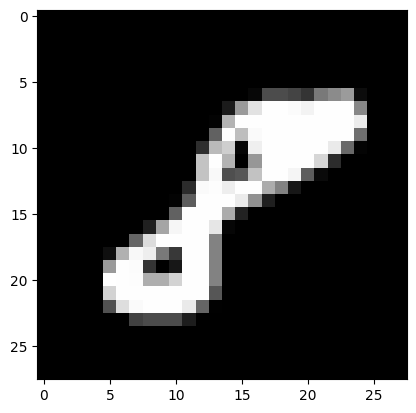

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

train_set = MNIST(root='/datasets', train=True,  transform=T.ToTensor(), download=True)
test_set  = MNIST(root='/datasets', train=False, transform=T.ToTensor(), download=True)

train_loader = DataLoader(train_set, batch_size=4096, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=4096, shuffle=True)

sample_batch = next(iter(train_loader))
plt.imshow(sample_batch[0][0][0], cmap='grey')
print(sample_batch[0].shape)

del train_set, test_set, sample_batch

Initialize KAN

In [3]:
# cubic spline (k=3), 3 grid intervals (grid=3).
model = KAN(width=[784, 10], grid=3, k=3, device=device, base_fun='silu')
model.to(device)

checkpoint directory created: ./model
saving model version 0.0


MultKAN(
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [4]:
def calculate_train_acc(model, dataset, one_hot=False):
    labels = dataset['train_label']
    if one_hot:
        labels = torch.argmax(dataset['train_label'], dim=1)
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == labels).float())

def calculate_test_acc(model, dataset, one_hot=False):
    with torch.no_grad():
        model.eval()
        labels = dataset['test_label']
        if one_hot:
            labels = torch.argmax(dataset['test_label'], dim=1)
    acc = torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == labels).float())
    model.train()
    return acc

def make_kan_dataset_from_batch(imgs, labels, train_split_proportion = 0.8):
    split_idx = int(len(imgs) * train_split_proportion)

    dataset = {}
    dataset['train_input'] = imgs[:split_idx].flatten(1)
    dataset['train_label'] = labels[:split_idx]
    dataset['test_input']  = imgs[split_idx:].flatten(1)
    dataset['test_label']  = labels[split_idx:]
    
    return dataset

Train KAN with sparsity regularization

In [5]:
def batch_training(model: MultKAN, train_loader):
    results = []

    for (imgs, labels) in train_loader:
        #labels = nn.functional.one_hot(labels, 10)
        dataset = make_kan_dataset_from_batch(imgs.to(device), labels.to(device), 0.8)

        batch_results = model.fit(
            dataset=dataset,
            opt="LBFGS",
            steps=3,
            #metrics=[train_acc, test_acc],
            lamb=0.001,
            loss_fn=nn.CrossEntropyLoss()
        )

        batch_results['train_acc'] = calculate_train_acc(model, dataset).item()
        batch_results['test_acc'] = calculate_test_acc(model, dataset).item()
        results.append(batch_results)
    return model, results

In [6]:
model, results = batch_training(model, train_loader)
results

| train_loss: 4.52e-01 | test_loss: 5.68e-01 | reg: 2.74e+02 | : 100%|█| 3/3 [00:05<00:00,  1.97s/it


saving model version 0.1


| train_loss: 4.31e-01 | test_loss: 5.94e-01 | reg: 2.72e+02 | : 100%|█| 3/3 [00:05<00:00,  1.74s/it


saving model version 0.2


| train_loss: 4.19e-01 | test_loss: 5.41e-01 | reg: 2.67e+02 | : 100%|█| 3/3 [00:05<00:00,  1.79s/it


saving model version 0.3


| train_loss: 4.09e-01 | test_loss: 6.28e-01 | reg: 2.69e+02 | : 100%|█| 3/3 [00:05<00:00,  1.77s/it


saving model version 0.4


| train_loss: 4.31e-01 | test_loss: 5.73e-01 | reg: 2.64e+02 | : 100%|█| 3/3 [00:05<00:00,  1.79s/it


saving model version 0.5


| train_loss: 4.23e-01 | test_loss: 6.15e-01 | reg: 2.76e+02 | : 100%|█| 3/3 [00:05<00:00,  1.70s/it


saving model version 0.6


| train_loss: 4.33e-01 | test_loss: 6.15e-01 | reg: 2.73e+02 | : 100%|█| 3/3 [00:05<00:00,  1.70s/it


saving model version 0.7


| train_loss: 4.34e-01 | test_loss: 6.12e-01 | reg: 2.72e+02 | : 100%|█| 3/3 [00:05<00:00,  1.74s/it


saving model version 0.8


| train_loss: 4.37e-01 | test_loss: 5.81e-01 | reg: 2.80e+02 | : 100%|█| 3/3 [00:05<00:00,  1.74s/it


saving model version 0.9


| train_loss: 4.18e-01 | test_loss: 5.62e-01 | reg: 2.77e+02 | : 100%|█| 3/3 [00:05<00:00,  1.77s/it


saving model version 0.10


| train_loss: 4.26e-01 | test_loss: 5.60e-01 | reg: 2.73e+02 | : 100%|█| 3/3 [00:05<00:00,  1.77s/it


saving model version 0.11


| train_loss: 4.30e-01 | test_loss: 5.97e-01 | reg: 2.80e+02 | : 100%|█| 3/3 [00:05<00:00,  1.74s/it


saving model version 0.12


| train_loss: 4.26e-01 | test_loss: 6.03e-01 | reg: 2.82e+02 | : 100%|█| 3/3 [00:05<00:00,  1.74s/it


saving model version 0.13


| train_loss: 4.14e-01 | test_loss: 5.67e-01 | reg: 2.78e+02 | : 100%|█| 3/3 [00:05<00:00,  1.79s/it


saving model version 0.14


| train_loss: 3.76e-01 | test_loss: 5.79e-01 | reg: 2.83e+02 | : 100%|█| 3/3 [00:03<00:00,  1.19s/it


saving model version 0.15


[{'train_loss': [array(0.61289958), array(0.50074253), array(0.45151171)],
  'test_loss': [array(0.64667127), array(0.57884919), array(0.56846051)],
  'reg': [array(274.57170767), array(278.60076289), array(273.75524317)],
  'train_acc': 0.9612332582473755,
  'test_acc': 0.9085366129875183},
 {'train_loss': [array(0.51038771), array(0.4628554), array(0.43091419)],
  'test_loss': [array(0.5950363), array(0.58975471), array(0.59354115)],
  'reg': [array(275.50852589), array(270.21685639), array(271.52301579)],
  'train_acc': 0.9694750308990479,
  'test_acc': 0.9036585092544556},
 {'train_loss': [array(0.48034542), array(0.44565467), array(0.41904516)],
  'test_loss': [array(0.53439418), array(0.53438234), array(0.54103795)],
  'reg': [array(284.44061659), array(269.47675641), array(266.67055436)],
  'train_acc': 0.9725275039672852,
  'test_acc': 0.9231707453727722},
 {'train_loss': [array(0.47769941), array(0.43443344), array(0.40932566)],
  'test_loss': [array(0.62475982), array(0.61944

In [7]:
#model = model.loadckpt('./model/0.31')
#model = model.prune()
#model = model.refine(10)
# model, results = batch_training(model, train_loader)
# results

In [8]:
results = []
for img, label in test_loader:
    dataset = make_kan_dataset_from_batch(img.to(device), label.to(device))
    dataset['test_label'] = nn.functional.one_hot(dataset['test_label'], 10)
    print(dataset['test_input'].shape, dataset['test_label'].shape)
    batch_results = model.evaluate(dataset)
    batch_results['test_acc'] = calculate_test_acc(model, dataset, one_hot=True).item()
    results.append(batch_results)

results

torch.Size([820, 784]) torch.Size([820, 10])
torch.Size([820, 784]) torch.Size([820, 10])
torch.Size([362, 784]) torch.Size([362, 10])


[{'test_loss': 3.3959235186435826,
  'n_edge': 7840,
  'n_grid': 3,
  'test_acc': 0.9024389982223511},
 {'test_loss': 3.3630879260594875,
  'n_edge': 7840,
  'n_grid': 3,
  'test_acc': 0.8926829099655151},
 {'test_loss': 3.389614636718438,
  'n_edge': 7840,
  'n_grid': 3,
  'test_acc': 0.9088398218154907}]